In [1]:
%matplotlib inline
import waves
import matplotlib.pyplot as plt
import numpy as np

A/D conversion
=============

In [2]:
CD = waves.CDFormatSampler('CD')

SACD = waves.DSDSampler('SACD', 64 * 44100, 16)

# DVD possible combinations (16-, 20- or 24-bits per sample)
# Channels                          | 44.1 kHz | 48 kHz | 88.2 kHz | 96 kHz | 176.4 kHz | 192 kHz
# Mono (1.0)                        |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.0)                      |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.1)                      |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# S+M surround (3.0 or 3.1)         |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Quad (4.0 or 4.1)                 |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo (3.0 or 3.1)             |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo+M surround (4.0 or 4.1)  |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Full surround (5.0 or 5.1)        |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
DVDA = waves.PCMSampler('DVD Audio', 88200, 20)

# High Fidelity Blu-ray Pure Audio uses 24 bits at 192 kHz (or also 96 kHz)
BDA = waves.HFPALinearPCM('Blu-Ray Audio')

# Generic, define sampling frequency (Hz) and resolution (bits) to your heart's content
GenericPCM_1 = waves.PCMSampler('Generic 1', 44100, 4) # Same CD frequency, lower resolution
GenericPCM_2 = waves.PCMSampler('Generic 2', 14000, 16) # Same CD resolution, lower frequency

CD's stream: [32768 37420 41979 46351 50447 54186 57490 60293 62539 64181 65186 65535
 65219 64246 62635 60419 57642 54362 50643 46563 42203 37651 33001 28346
 23780 19397 15285 11527  8199  5369  3095  1422   384     2   284  1225
  2804  4991  7741 10998 14697 18761 23109 27653 32301 36958 41530 45924
 50052 53830 57181 60037 62340 64045 65115 65530 65281 64373 62824 60667
 57944 54711 51033 46985 42649 38112 33468 28809 24230 19825 15681 11884
  8510  5628  3296  1561   458    10   226  1101  2619  4747  7443 10652
 14309 18340 22664 27192 31834 36494 41079 45496 49654 53470 56867 59775
 62136 63902 65037 65518 65335 64493 63007 60909 58240 55055 51418 47404
 43093 38572 33934 29273 24682 20255 16081 12246  8827  5893  3503  1706
   539    25   175   985  2439  4507  7149 10309 13925 17923 22221 26733
 31367]
Generic 1's stream: [ 8  9 10 11 12 12 13 14 14 15 15 15 15 15 14 14 13 12 12 11 10  9  8  6
  5  4  3  3  2  1  1  0  0  0  0  0  1  1  2  3  3  4  5  6  7  8 10 11
 11 12 13 

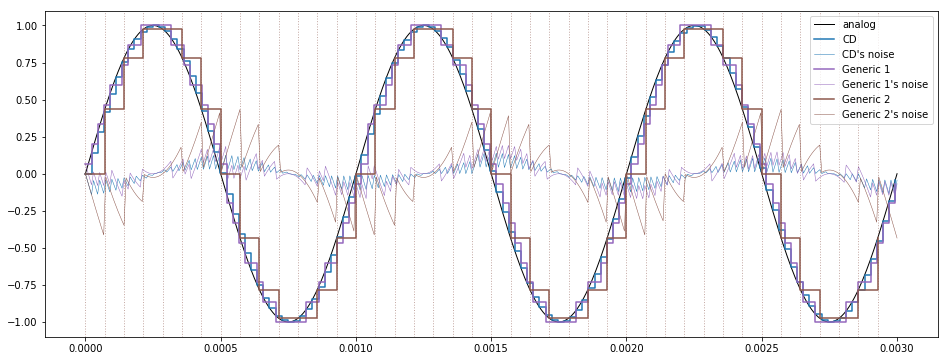

In [3]:
f = 1e3 # 1KHz
audio = waves.AnalogSineWave('analog', f, phase=0)
n_waves = 3
length = n_waves * 1/f

audio.plot(length, plt, color='k', lw=1)
CD.sample(audio, length, plt, lw=1.5)
##SACD.sample(audio, length, plt, color='b', lw=1.5)
#DVDA.sample(audio, length, plt, color='g', lw=1.5)
#BDA.sample(audio, length, plt, color='m', lw=1.5)
GenericPCM_1.sample(audio, length, plt, lw=1.5)
GenericPCM_2.sample(audio, length, plt, lw=1.5)
[plt.axvline(t, color=GenericPCM_2.color, lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, GenericPCM_2.sampling_interval)]
#[plt.axhline(A, color='b', lw=1, ls=':', alpha=0.5) for A in np.linspace(audio.Amin, audio.Amax, GenericPCM.levels)]
plt.legend()
plt.gcf().set_size_inches(16, 6)

Let us now add some dither and see how the noise behaves

CD's stream: [32567 38013 43970 45503 47686 46146 52583 56691 56333 58701 61538 68178
 65870 58330 64013 52740 54386 55924 43099 52956 47330 39564 31932 27545
 26743 28749 13958 13767 -1498 14714  2777    81  5411   801 -3164 11020
  3505  2846 10931  -183 17005 20189 15615 29909 34576 39807 43523 48233
 53452 49995 54301 60507 55301 69567 65443 68118 66969 63074 57443 60609
 53887 61164 52169 44871 35962 38111 36173 29363 28745 16358 12961 13513
  9143 -1221   646  3934  3352 -1445  7644 -6598  3104   946  3526  9042
 18115 15358 23313 26260 27154 33978 46203 41912 49190 54962 50471 62564
 59724 59727 61792 60048 60236 59671 60801 61044 51840 55819 45344 55934
 45627 48202 30507 24097 23814 12304 16917  5007  6731 11795 12223 11685
  8335 -4845    -8  4775 -1031 -2716  -327  8876 14269 16596 18369 24959
 32985]
Generic 1's stream: [ 8  8 10 12 12 12 13 14 15 15 15 14 13 14 12 13 14 10 11 12  8  7  6  5
  3  5  3  3  2  0  2 -1  0  1 -2  1 -1  0  3  3  3  5  5  6  8  7  9 11
 12 11 13 

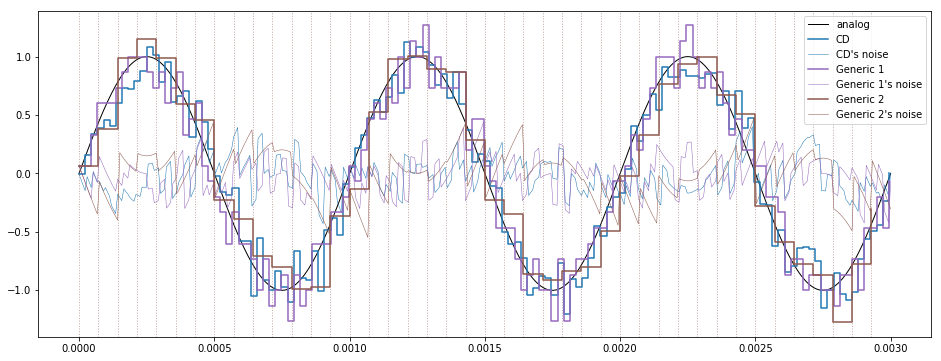

In [6]:
audio.plot(length, plt, color='k', lw=1)
CD.sample(audio, length, plt, dither=0.35, lw=1.5)
##SACD.sample(audio, length, plt, color='b', lw=1.5)
#DVDA.sample(audio, length, plt, color='g', lw=1.5)
#BDA.sample(audio, length, plt, color='m', lw=1.5)
GenericPCM_1.sample(audio, length, plt, dither=0.35, lw=1.5)
GenericPCM_2.sample(audio, length, plt, dither=0.35, lw=1.5)
[plt.axvline(t, color=GenericPCM_2.color, lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, GenericPCM_2.sampling_interval)]
#[plt.axhline(A, color='b', lw=1, ls=':', alpha=0.5) for A in np.linspace(audio.Amin, audio.Amax, GenericPCM.levels)]
plt.legend()
plt.gcf().set_size_inches(16, 6)

The noise is now more decorrelated from the signal, at the cost of increased noise power